In [38]:
# modules importation
from trends_functions import *
import pickle
import os
from warnings import filterwarnings
filterwarnings('ignore')

In [39]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.2
sns.set(font_scale=fscale)

In [40]:
# computation parameters
params = get_params()

In [41]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'concpm10' 'concpm25' 'concso4' 'scatc550dryaer' 'absc550aer'
var = 'absc550aer'
params['kind'] = 'obs'
params = fill_params(params, var)
params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [42]:
print('OBS')
OBS_TS, OBS_MAP, OBS_DF = process_trend(
    obs_data, params,
    plot=False, show_plot=False, save_plot=False, write_json=False
)

OBS
excluding module
region:  EUROPE station:  Vavihillmospheric Research Observatoryt
Less than 7 points in selected period
excluding module
region:  ASIA station:  Gosanon-do
Less than 7 points in selected period
excluding module
excluding moduleA station:  Trinidad Headt Plains E13
excluding moduleA station:  Cape San Juan
exclude  Granada
region:  NAFRICA station:  Finokaliaillo
Less than 7 points in selected period
excluding module
No station found in , AUSTRALIA Point
excluding module
exclude  Alert
exclude  Granada


In [43]:
params['kind'] = 'mod' 
params['min_dim'] = 0

mod_var = params['mod_var']
mod_source = params['ref_model']

print(mod_source)
print()

#check if model in cache
fn = 'cache/'+mod_source+'_'+var+'.pkl'
if os.path.isfile(fn):
    print('use pickle')
    # for reading also binary mode is important 
    pklfile = open(fn, 'rb')      
    mod_data = pickle.load(pklfile) 
    pklfile.close()
else:
    reader = pya.io.ReadGridded(mod_source)
    if (var=='scatc550dryaer'):
        mod_data = reader.read_var(mod_var, ts_type='daily', aux_fun=pya.io.aux_read_cubes.subtract_cubes, aux_vars=['ec550dryaer', 'absc550aer'])
    else:
        mod_data = reader.read_var(mod_var, ts_type='daily')
    #if cube has 4 dimensions, extract first level
    if mod_var in ['concso4', 'concpm10', 'concpm25', 'scatc550dryaer', 'absc550aer'] and len(np.shape(mod_data))==4:
        print('cube has 4 dimension, extract first layer')
        mod_data = mod_data.extract_surface_level()
    mod_data = mod_data.resample_time(to_ts_type='monthly')

    try:
        #write picke file in cache directory
        pklfile = open(fn, 'ab') 

        # source, destination 
        pickle.dump(mod_data, pklfile)                      
        pklfile.close()
    except AttributeError:
        print('AttributeError')
        os.remove(fn)

NorESM2-CPL-NEWTEST_HIST

cube has 4 dimension, extract first layer
AttributeError


In [44]:
#crop the cube to interest period, so can handle WORLD region
mod_data = mod_data.crop(time_range=(params['period'].split('-')[0], str(int(params['period'].split('-')[1])+1)))

In [45]:
#full colocation
print('#full colocation')
MOD_TS, MOD_MAP, MOD_DF = process_trend(
    mod_data, params, obs=obs_data,
    colocate_time=True, colocate_space=True, 
    OBS_DF = OBS_DF,
    plot=False, show_plot=False, save_plot=False, write_json=False
)

#full colocation
colocate monthly dataframes Trinidad Headt Plains E13
No station found in  AUSTRALIA
colocate monthly dataframesppelin mountain (Ny-Ålesund)ervatoryt


In [46]:
#space colocation only
print('#space colocation only')
ALLTS_MOD_TS, ALLTS_MOD_MAP, ALLTS_MOD_DF = process_trend(
    mod_data, params, obs=obs_data, 
    colocate_time=False, colocate_space=True,
    OBS_DF = OBS_DF,
    plot=False, show_plot=False, save_plot=False, write_json=False, 
)

#space colocation only
No station found in  AUSTRALIAinidad Headt Plains E13


In [47]:
#all pixels in region
print('#all pixels in region')
REG_MOD_TS, REG_MOD_MAP, REG_MOD_DF = process_trend(
    mod_data, params, obs=obs_data, 
    colocate_time=False, colocate_space=False, 
    OBS_DF = OBS_DF,
    plot=False, show_plot=False, save_plot=False, write_json=False, 
)

#all pixels in region
No station found in  AUSTRALIA


In [48]:
#print the results
print(' * * OBS * *')
print_trends(OBS_MAP)
print(' * * MOD * *')
print_trends(MOD_MAP)
print(' * * ALLTS_MOD * *')
print_trends(ALLTS_MOD_MAP)
print(' * * REG_MOD * *')
print_trends(REG_MOD_MAP)

 * * OBS * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
AUSTRALIA 	 Key Error
SAFRICA 	 Key Error
NAMER 	 2000-2014 	 ( -0.1 ± 3.7 ) 	 0.9
SAMERICA 	 Key Error
WORLD 	 2000-2014 	 ( 1.5 ± 4.4 ) 	 0.56

 * * MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROPE 	 Key Error
ASIA 	 Key Error
AUSTRALIA 	 Key Error
NAFRICA 	 Key Error
SAFRICA 	 Key Error
NAMER 	 2000-2014 	 ( -1.2 ± 1.7 ) 	 0.26
SAMERICA 	 Key Error
WORLD 	 2000-2014 	 ( 6.0 ± 7.9 ) 	 0.28

 * * ALLTS_MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROPE 	 Key Error
ASIA 	 Key Error
AUSTRALIA 	 Key Error
NAFRICA 	 Key Error
SAFRICA 	 Key Error
NAMER 	 2000-2014 	 ( 0.2 ± 1.1 ) 	 0.77
SAMERICA 	 Key Error
WORLD 	 2000-2014 	 ( -0.3 ± 0.8 ) 	 0.56

 * * REG_MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROP 	 2000-2014 	 ( 0.4 ± 0.8 ) 	 0.5
ASIA 	 2000-2014 	  2.9 ± 0.5  	 0.0
AUSTRALIA 	 Key Error
NAFRI 	 2000-2014 	  0.4 ± 0.7  	 0.14


In [49]:
#computation region by region
print(var)
print(' * * CONSISTENCY * *')
print_consistency(MOD_MAP, ALLTS_MOD_MAP, REG_MOD_MAP, kind='rel')

absc550aer
 * * CONSISTENCY * *
region   period   slp (%/yr)   allTS-slp (%/yr)   reg-slp (%/yr)   time_consist   space_consist   consist
 - - -    - - -    - - - - - - -    - - - - - - -    - - - - - - -    - - - - - -    - - - - - - 
EUROPE Key Error
ASIA Key Error
AUSTRALIA Key Error
NAFRICA Key Error
SAFRICA Key Error
NAMER 	 2000-2014 	 -1.2 	 0.2 	 0.7 	  28 	  82  	  55 	
SAMERICA Key Error



In [50]:
#plot Normal distribution
def norm_dist(diff):
    norm = 1
    mu = 0
    stdv = 0.50
    gauss = 100*norm*np.exp(-0.5*(((diff-mu)/stdv)**2))
    
    consistency = gauss
    return consistency

In [51]:
regions = ['EUROPE', 'ASIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA', 'AUSTRALIA', 'WORLD']
MOD = MOD_MAP
ALLTS_MOD = ALLTS_MOD_MAP
REG_MOD = REG_MOD_MAP
key_slope = 'rel_slp'
kind = 'rel'

tab = []

for region in regions:
    #get trends keys
    try:
        periods = MOD[region]['trends']['trends'].keys()
    except KeyError:
        print(region,'Key Error')
        continue
    for p, per in enumerate(periods):
        try:
            r = MOD[region]['trends']['trends'][per]
            allts_r = ALLTS_MOD[region]['trends']['trends'][per]
            reg_r = REG_MOD[region]['trends']['trends'][per]
        except KeyError:
            print('\t',per,'\t','Key Error')
            continue

        str_region = region

        if r[key_slope]!=None and allts_r[key_slope]:
            slp = r[key_slope]
            allts_slp = allts_r[key_slope]
            reg_slp = reg_r[key_slope]
            
            time_diff = abs(allts_slp - slp)
            space_diff = abs(reg_slp - allts_slp)
            all_diff = np.mean([time_diff, space_diff])
            
            time_consist = norm_dist(time_diff)
            space_consist = norm_dist(space_diff)
            all_consist = np.mean([time_consist, space_consist])

        else:
            time_diff = np.nan
            space_diff = np.nan
            time_consist = np.nan
            space_consist = np.nan
            all_consist = np.nan
            accuracy = np.nan

        print(params['ylabel'],str_region, per, 
              round(slp,1), round(allts_slp,1), round(reg_slp,1), 
              round(time_diff,1), round(space_diff,1), round(all_diff,1), 
              round(time_consist,1), round(space_consist,1), round(all_consist,1)
             )
        tab.append([params['ylabel'],str_region, per, all_consist])
        
head_df = ['Parameter', 'Region', 'Segment', 'Representativity']
df = pd.DataFrame(tab, columns=head_df).set_index(['Parameter', 'Region', 'Segment'])

# write dataframe
pklfile = open('cache/repr/' + var + '.pkl', 'wb')
# source, destination
pickle.dump(df, pklfile)
pklfile.close()
# - - - - - - - - - - - - - - - - - - - - - -

EUROPE Key Error
ASIA Key Error
NAFRICA Key Error
SAFRICA Key Error
Abs. Coef. NAMERICA 2000-2014 -1.2 0.2 0.7 1.4 0.5 0.9 2.4 56.4 29.4
SAMERICA Key Error
AUSTRALIA Key Error
Abs. Coef. WORLD 2000-2014 6.0 -0.3 1.4 6.3 1.7 4.0 0.0 0.3 0.2


In [52]:
df

Representativity
Parameter  Region   Segment                    
Abs. Coef. NAMERICA 2000-2014         29.423400
           WORLD    2000-2014          0.162995

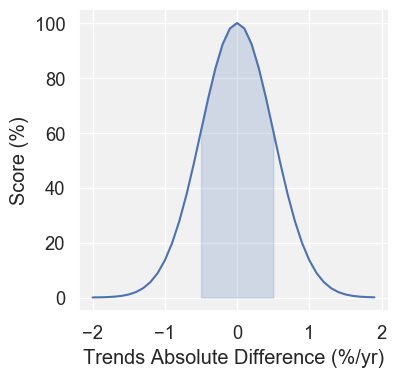

In [53]:
x = np.arange(-2,2,0.1)
y = norm_dist(x)

fig, ax = plt.subplots(figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(x, y)

#add info in main axis
ax = fig.axes[0]
ax.set_ylabel('Score (%)')
ax.set_xlabel('Trends Absolute Difference (%/yr)')


ax.set_facecolor('#F1F1F1')
plt.savefig('figs/norm_dist.png', dpi=300, bbox_inches='tight')

#color area of the curve above n%
thr = 50
xok, yok = [], []
for i, _ in enumerate(y):
    if y[i]>=thr:
        xok.append(x[i])
        yok.append(y[i])

plt.fill_between(xok, yok, color='b', alpha=0.2)
plt.savefig('figs/norm_dist_filled.png', dpi=300, bbox_inches='tight')


KeyError: 'EUROPE'

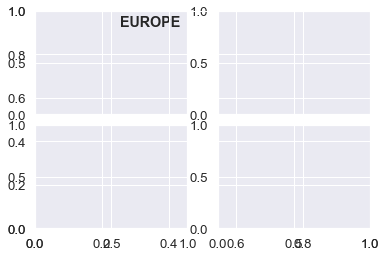

In [54]:
regions = ['EUROPE', 'NAMERICA']

#make figure of time series for n regions
nl, nc = 2, len(regions)
fig, axs = plt.subplots(nl, nc, sharex='col', sharey=False, 
                       gridspec_kw={
                           'wspace': 0.2,
                           'hspace': 0.1
                       })
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)

current_palette = sns.color_palette()

for i, region in enumerate(regions):

        
    #first figure: number of observations
    ax = axs[0, i]
    #ax.set_title(region, fontweight='bold')
    ax.text(0.95, 0.85,region,ha='right', fontweight='bold',transform=ax.transAxes)
    
    #full colocation
    odf = OBS_DF[region]
    n = odf.count(axis=1, numeric_only=False)
    n = n.resample('M', how='mean')
    ax.plot(n.index, n.values, color=current_palette[0])
    #space colocation
    ax.plot(n.index, [ALLTS_MOD_MAP[region]['nmax'] for i in n.index], color=current_palette[1])
    #full domain
    ax.plot(n.index, [REG_MOD_MAP[region]['nmax'] for i in n.index], color=current_palette[2])
    #ax.text(0.97,0.90,'N: {:d}'.format(REG_MOD_MAP[region]['nmax']), color=current_palette[2], ha='right', transform=ax.transAxes)
    
    
    ax.set_facecolor('#F1F1F1')
    ax.set_ylabel('Number of Points')
    ax.set_xlim('2000-01-01','2015-01-01')
    ax.set_ylim(1,1e4)
    ax.set_yscale('symlog')
    
    
    #second figure
    ax = axs[1, i]
    ax.set_facecolor('#F1F1F1')
    #MOD_MAP, ALLTS_MOD_MAP, REG_MOD_MAP
    ts1 = MOD_MAP[region]['trends']
    ts2 = ALLTS_MOD_MAP[region]['trends']
    ts3 = REG_MOD_MAP[region]['trends']
    
    dy = 0.12
    
    ax.plot(js2date(ts1['monthly']['jsdate']),ts1['monthly']['data'], ':', color=current_palette[0], alpha=0.5)
    ax.plot(js2date(ts1['yearly']['jsdate']),ts1['yearly']['data'], '.', label='a', color=current_palette[0])
    ax.plot(js2date(ts1['trends'][params['period']]['jsdate']),ts1['trends'][params['period']]['data'], ls='-', color=current_palette[0], label='')
    ax.text(0.97,0.9,'{:+.1f}%/yr'.format(ts1['trends'][params['period']]['rel_slp']),ha='right',transform=ax.transAxes, color=current_palette[0])
    
    ax.plot(js2date(ts2['monthly']['jsdate']),ts2['monthly']['data'], ':', color=current_palette[1], alpha=0.5)
    ax.plot(js2date(ts2['yearly']['jsdate']),ts2['yearly']['data'], '.', label='b', color=current_palette[1])
    ax.plot(js2date(ts2['trends'][params['period']]['jsdate']),ts2['trends'][params['period']]['data'], ls='-', color=current_palette[1])
    ax.text(0.97,0.9-dy,'{:+.1f}%/yr'.format(ts2['trends'][params['period']]['rel_slp']),ha='right',transform=ax.transAxes, color=current_palette[1])
    
    ax.plot(js2date(ts3['monthly']['jsdate']),ts3['monthly']['data'], ':', color=current_palette[2], alpha=0.5)
    ax.plot(js2date(ts3['yearly']['jsdate']),ts3['yearly']['data'], '.', label='c', color=current_palette[2])
    ax.plot(js2date(ts3['trends'][params['period']]['jsdate']),ts3['trends'][params['period']]['data'], ls='-', color=current_palette[2])
    ax.text(0.97,0.90-2*dy,'{:+.1f}%/yr'.format(ts3['trends'][params['period']]['rel_slp']),ha='right',transform=ax.transAxes, color=current_palette[2])
    
    #print out representativity
    ax.text(0.97,0.90-3*dy,'Rep: {:.1f}%'.format(df['Representativity'][params['ylabel']][region][params['period']]),ha='right',fontweight='bold', transform=ax.transAxes)
    
    
    ax.set_ylim(0,0.4)
    #ax.set_ylim(0,100)
    ax.set_xlim('2000-01-01','2015-01-01')
    ax.set_ylabel(params['ylabel'])

#change size of the figure
# hide tick and tick label of the big axes
plt.tick_params(labelcolor=None, top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xticks([])
plt.yticks([])

handles, labels = ax.get_legend_handles_labels()
labels = ['$Ref_{t}$', '$Exp_{t} / Ref_{s}$', '$Exp_{s}$']
fig.legend(handles, labels, loc='lower center', ncol=3, facecolor='white')

fig.set_size_inches(16,7)
fig = plt.gcf()
plt.savefig('figs/representativity-'+var+'.png', dpi=300, bbox_inches='tight')